In [1]:
#########################################################
## Python SKLearn - fit Non Negative Matrix Factorization to sparse DTM
##
## We tune the NMF topic model using hyperopt --- optimizing over topical coherence as a metric
##
## Author: Chris Meaney
## Date: January 2023
#########################################################

In [2]:
################################
## Dependency Modules
################################

## Timing
import time

## Numerics
import numpy as np

## Sparse matrix support
import scipy.sparse

## Pandas data structures
import pandas as pd

## Factorizations/deomcposions
from sklearn.decomposition import NMF

## Topic coherence
import logging
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

## Hyper-parameter tuning
from hyperopt import STATUS_OK, Trials, fmin, hp
from hyperopt.tpe import suggest

## Session info
#from sinfo import sinfo

## Plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## Plotting
import seaborn as sns

In [3]:
## Pandas options for Jupyter Notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

In [4]:
## Random seed/state
rand_ = 123421

In [5]:
###################################
## Import IJX sparse matrix data
###################################
fpath_ijx = "D:\\CopyZ_30Nov2020\\DFCM_Docs\\DFCM_Researchers\\PeterSelby\\MineScopus_DFCM_National_International_PrimaryCareResearchPrograms\\Output_TopicModels\\ijx_df.csv"

ijx_dtm = pd.read_csv(filepath_or_buffer=fpath_ijx,
                      delimiter=",",
                      header=0)

ijx_dtm.shape

(1101775, 3)

In [6]:
## Max of row/col indices
(np.max(ijx_dtm.i), np.max(ijx_dtm.j))

(12276, 48821)

In [7]:
##
## Convert from IJX format into Scipy.Sparse format
##
nrow = np.max(ijx_dtm.i)
ncol = np.max(ijx_dtm.j)

sp_dtm = scipy.sparse.coo_matrix((ijx_dtm.x, (ijx_dtm.i-1, ijx_dtm.j-1)), shape=(nrow,ncol))
sp_dtm.shape

(12276, 48821)

In [8]:
#####################################################
## Import additional feature/covariate information
#####################################################
fpath_x = "D:\\CopyZ_30Nov2020\\DFCM_Docs\\DFCM_Researchers\\PeterSelby\\MineScopus_DFCM_National_International_PrimaryCareResearchPrograms\\Output_TopicModels\\X.csv"

X = pd.read_csv(filepath_or_buffer=fpath_x,
                      delimiter=",",
                      header=0,
                      encoding='latin1')

In [9]:
(X.shape, X.columns.values)

((12276, 26),
 array(['au_id', 'prism_url', 'eid', 'doi', 'issn', 'eissn', 'pub_title',
        'pub_author', 'pub_journal', 'pub_date', 'pub_abstract',
        'pub_keywords', 'pub_type', 'pub_subtype', 'open_access',
        'fund_acr', 'fund_num', 'fund_sponsor', 'cited_count', 'nam', 'id',
        'pub_year', 'au_country', 'au_institution', 'au_name',
        'au_institution_country'], dtype=object))

In [10]:
#####################################################
## Import dictionary/vocab file
#####################################################
fpath_vocab = "D:\\CopyZ_30Nov2020\\DFCM_Docs\\DFCM_Researchers\\PeterSelby\\MineScopus_DFCM_National_International_PrimaryCareResearchPrograms\\Output_TopicModels\\vocab.csv"

vocab = pd.read_csv(filepath_or_buffer=fpath_vocab,
                      delimiter=",",
                      header=0,
                      encoding='latin1')

(vocab.shape, vocab.columns.values)

((48821, 1), array(['vocab'], dtype=object))

In [11]:
# vocab.vocab.tolist()

In [12]:
################################################################
## Import text data --- used to generate Gensim corpus object
################################################################
fpath_texts = "D://CopyZ_30Nov2020//DFCM_Docs//DFCM_Researchers//PeterSelby//MineScopus_DFCM_National_International_PrimaryCareResearchPrograms//Output_TopicModels//parsed_texts.csv"

x = pd.read_csv(filepath_or_buffer=fpath_texts,
                      delimiter=",",
                      header=0,
                      encoding='latin1')

In [13]:
texts = x.x.to_list()

In [14]:
texts_ = [txt.split(" ") for txt in texts]
#texts_[0:3]

In [15]:
##
## Use Gensim to constuct corpus/dictionary
##

In [16]:
dictionary = Dictionary(texts_)
type(dictionary)

gensim.corpora.dictionary.Dictionary

In [17]:
len(dictionary)

48821

In [18]:
corpus = [dictionary.doc2bow(txt) for txt in texts_]
type(corpus)

list

In [19]:
len(corpus)

12276

In [20]:
##########################################################
## Set up hyperopt experiment/trials for NMF model --- relative to topical coherence metrics
##########################################################

In [21]:
##
## Compute loss function
##
def get_loss(params):
    ## Instantiate NMF model
    model = NMF(**params)
    ## Fit NMF model to training data and extract theta matrix
    theta = model.fit_transform(sp_dtm)
    theta_pd = pd.DataFrame(theta)
    theta_pd.columns = ["Topic" + str(num+1) for num in range(theta_pd.shape[1])]
    ## Get phi matrix
    phi = model.components_
    phi_pd = pd.DataFrame(phi)
    phi_pd.columns =vocab.vocab.tolist()
    ## Extract topics defining fit
    topics_list = []
    num_topics = phi_pd.shape[0]
    for k in np.arange(num_topics):
        ## Tmp placeholder for vector
        tmp = phi_pd.iloc[k,:].sort_values(ascending=False)
        ## Get words
        words = tmp.index
        ## Get top words
        top_words = pd.Series(words).head(n=10).to_list()
        ## Append to topic list
        topics_list.append(top_words)
    ## Extract topic coherence score associated with topical vectors from model fit
    coherence_metric = CoherenceModel(topics=topics_list,
                                     dictionary=dictionary,
                                     corpus=corpus,
                                     texts=texts_,
                                     coherence='c_npmi').get_coherence()
    ## Convert to minimization of metric (rather than maximization of coherence)
    loss = -1*coherence_metric
    ## Return loss to user
    return {'loss': loss, 'status': STATUS_OK}

In [22]:
##
## Define hyper-parameter optimization function, and HPO search space
##
def optimize(rand=rand_):
    space = {
        'n_components': hp.randint('n_components', 250) + 2,       ## Number of latent topics
        'max_iter': hp.randint('max_iter', 300) + 100,             ## Number of iterations for stochastic algorithm
        'solver': hp.choice('solver', ['cd','mu']),                ## Coordinate descent vs. multiplicative updates
        'beta_loss': hp.choice('beta_loss', ['frobenius']),        ## Frobenius norm loss function
        'init': hp.choice('init', ['random']),                     ## Random initialization
        'alpha_H': hp.uniform('alpha_H', 0, 0.00001),              ## Regularization on phi matrix - topical vectors
        'alpha_W': hp.uniform('alpha_W', 0, 0.00001),              ## Regularization on theta matrix - per doc topic weights
        'l1_ratio': hp.uniform('l1_ratio', 0, 1),                  ## Lasso vs. Ridge penalty
        'random_state': rand
    }
    ## Evaluate model
    opt_model = fmin(get_loss, space, algo=suggest, max_evals=100, trials=trials)
    ## Return best model to user
    return opt_model

In [23]:
##
## Initialize a trials object
##
trials = Trials()

In [24]:
##
## Run hyperopt function for 100 trials
##
t0 = time.time()
best_hyper_params = optimize()
t1 = time.time()

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 240 reached. Increase it to improve convergence.
  ConvergenceWarning,



  1%|▍                                         | 1/100 [07:16<12:00:01, 436.38s/trial, best loss: -0.08217586288750219]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 112 reached. Increase it to improve convergence.
  ConvergenceWarning,



  2%|▊                                          | 2/100 [08:37<6:10:59, 227.14s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 239 reached. Increase it to improve convergence.
  ConvergenceWarning,



  3%|█▎                                         | 3/100 [11:53<5:44:52, 213.33s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 314 reached. Increase it to improve convergence.
  ConvergenceWarning,



  4%|█▋                                         | 4/100 [12:11<3:37:45, 136.10s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 110 reached. Increase it to improve convergence.
  ConvergenceWarning,



  5%|██▏                                        | 5/100 [12:47<2:38:27, 100.07s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 395 reached. Increase it to improve convergence.
  ConvergenceWarning,



  7%|███                                        | 7/100 [17:24<3:22:14, 130.48s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 132 reached. Increase it to improve convergence.
  ConvergenceWarning,



  9%|███▊                                       | 9/100 [21:41<3:16:46, 129.74s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 242 reached. Increase it to improve convergence.
  ConvergenceWarning,



 10%|████▏                                     | 10/100 [34:55<8:22:09, 334.77s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 347 reached. Increase it to improve convergence.
  ConvergenceWarning,



 11%|████▌                                    | 11/100 [59:32<16:55:00, 684.27s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 118 reached. Increase it to improve convergence.
  ConvergenceWarning,



 12%|████▋                                  | 12/100 [1:02:39<13:01:40, 532.96s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 213 reached. Increase it to improve convergence.
  ConvergenceWarning,



 13%|█████                                  | 13/100 [1:07:20<11:02:10, 456.67s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 188 reached. Increase it to improve convergence.
  ConvergenceWarning,



 15%|██████                                  | 15/100 [1:11:54<6:44:55, 285.84s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 393 reached. Increase it to improve convergence.
  ConvergenceWarning,



 16%|██████▍                                 | 16/100 [1:21:32<8:43:18, 373.79s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 377 reached. Increase it to improve convergence.
  ConvergenceWarning,



 17%|██████▊                                 | 17/100 [1:29:35<9:22:42, 406.78s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 113 reached. Increase it to improve convergence.
  ConvergenceWarning,



 20%|████████                                | 20/100 [1:41:09<6:05:53, 274.42s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 344 reached. Increase it to improve convergence.
  ConvergenceWarning,



 21%|████████▍                               | 21/100 [1:48:33<7:08:06, 325.14s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 286 reached. Increase it to improve convergence.
  ConvergenceWarning,



 22%|████████▊                               | 22/100 [1:53:46<6:58:08, 321.65s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 286 reached. Increase it to improve convergence.
  ConvergenceWarning,



 23%|█████████▏                              | 23/100 [1:57:29<6:14:48, 292.06s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 394 reached. Increase it to improve convergence.
  ConvergenceWarning,



 24%|█████████▎                             | 24/100 [2:21:57<13:36:55, 644.94s/trial, best loss: -0.12140730204363143]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 208 reached. Increase it to improve convergence.
  ConvergenceWarning,



 26%|██████████▍                             | 26/100 [2:26:38<7:47:29, 379.05s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 208 reached. Increase it to improve convergence.
  ConvergenceWarning,



 27%|██████████▌                            | 27/100 [2:40:15<10:20:58, 510.38s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 172 reached. Increase it to improve convergence.
  ConvergenceWarning,



 28%|███████████▏                            | 28/100 [2:42:25<7:55:25, 396.19s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 112 reached. Increase it to improve convergence.
  ConvergenceWarning,



 29%|███████████▌                            | 29/100 [2:45:59<6:44:12, 341.59s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 232 reached. Increase it to improve convergence.
  ConvergenceWarning,



 31%|████████████▍                           | 31/100 [2:58:15<6:30:00, 339.14s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 302 reached. Increase it to improve convergence.
  ConvergenceWarning,



 33%|█████████████▏                          | 33/100 [3:07:22<5:25:48, 291.77s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 104 reached. Increase it to improve convergence.
  ConvergenceWarning,



 34%|█████████████▌                          | 34/100 [3:11:18<5:02:40, 275.16s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 237 reached. Increase it to improve convergence.
  ConvergenceWarning,



 37%|██████████████▊                         | 37/100 [3:33:29<6:09:00, 351.44s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 126 reached. Increase it to improve convergence.
  ConvergenceWarning,



 39%|███████████████▌                        | 39/100 [3:34:04<3:03:57, 180.94s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 160 reached. Increase it to improve convergence.
  ConvergenceWarning,



 40%|████████████████                        | 40/100 [3:42:10<4:32:31, 272.52s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 142 reached. Increase it to improve convergence.
  ConvergenceWarning,



 41%|████████████████▍                       | 41/100 [3:46:26<4:23:06, 267.57s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 279 reached. Increase it to improve convergence.
  ConvergenceWarning,



 42%|████████████████▊                       | 42/100 [4:02:36<7:42:19, 478.27s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 103 reached. Increase it to improve convergence.
  ConvergenceWarning,



 44%|█████████████████▌                      | 44/100 [4:05:21<4:17:21, 275.73s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 108 reached. Increase it to improve convergence.
  ConvergenceWarning,



 46%|██████████████████▍                     | 46/100 [4:08:57<2:44:19, 182.58s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 345 reached. Increase it to improve convergence.
  ConvergenceWarning,



 47%|██████████████████▊                     | 47/100 [4:32:11<8:02:17, 545.98s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 133 reached. Increase it to improve convergence.
  ConvergenceWarning,



 48%|███████████████████▏                    | 48/100 [4:34:53<6:13:11, 430.61s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 112 reached. Increase it to improve convergence.
  ConvergenceWarning,



 50%|████████████████████                    | 50/100 [4:38:58<3:46:00, 271.21s/trial, best loss: -0.12269596385611328]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 305 reached. Increase it to improve convergence.
  ConvergenceWarning,



 51%|████████████████████▍                   | 51/100 [4:41:03<3:05:43, 227.43s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 204 reached. Increase it to improve convergence.
  ConvergenceWarning,



 52%|████████████████████▊                   | 52/100 [4:41:59<2:20:41, 175.86s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 305 reached. Increase it to improve convergence.
  ConvergenceWarning,



 53%|█████████████████████▏                  | 53/100 [5:05:26<7:07:04, 545.20s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 362 reached. Increase it to improve convergence.
  ConvergenceWarning,



 54%|█████████████████████                  | 54/100 [5:32:17<11:03:10, 865.02s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 305 reached. Increase it to improve convergence.
  ConvergenceWarning,



 55%|████████████████████▉                 | 55/100 [5:55:22<12:45:47, 1021.04s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 131 reached. Increase it to improve convergence.
  ConvergenceWarning,



 56%|██████████████████████▍                 | 56/100 [5:56:06<8:53:55, 728.08s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 322 reached. Increase it to improve convergence.
  ConvergenceWarning,



 57%|██████████████████████▊                 | 57/100 [6:03:17<7:37:55, 638.96s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 382 reached. Increase it to improve convergence.
  ConvergenceWarning,



 58%|███████████████████████▏                | 58/100 [6:04:07<5:23:33, 462.22s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 277 reached. Increase it to improve convergence.
  ConvergenceWarning,



 59%|███████████████████████▌                | 59/100 [6:07:28<4:22:20, 383.91s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 301 reached. Increase it to improve convergence.
  ConvergenceWarning,



 60%|████████████████████████                | 60/100 [6:09:33<3:24:03, 306.10s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 324 reached. Increase it to improve convergence.
  ConvergenceWarning,



 61%|████████████████████████▍               | 61/100 [6:12:14<2:50:37, 262.49s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  ConvergenceWarning,



 62%|████████████████████████▊               | 62/100 [6:13:46<2:13:49, 211.31s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 315 reached. Increase it to improve convergence.
  ConvergenceWarning,



 63%|█████████████████████████▏              | 63/100 [6:15:52<1:54:39, 185.94s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 149 reached. Increase it to improve convergence.
  ConvergenceWarning,



 64%|█████████████████████████▌              | 64/100 [6:17:48<1:38:52, 164.78s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 156 reached. Increase it to improve convergence.
  ConvergenceWarning,



 65%|██████████████████████████              | 65/100 [6:29:27<3:09:41, 325.19s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 175 reached. Increase it to improve convergence.
  ConvergenceWarning,



 66%|██████████████████████████▍             | 66/100 [6:38:07<3:37:23, 383.63s/trial, best loss: -0.12661810537764442]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 222 reached. Increase it to improve convergence.
  ConvergenceWarning,



 67%|██████████████████████████▊             | 67/100 [6:40:06<2:47:20, 304.25s/trial, best loss: -0.12664073120810837]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 192 reached. Increase it to improve convergence.
  ConvergenceWarning,



 68%|███████████████████████████▏            | 68/100 [6:54:43<4:13:49, 475.92s/trial, best loss: -0.12664073120810837]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 324 reached. Increase it to improve convergence.
  ConvergenceWarning,



 69%|███████████████████████████▌            | 69/100 [7:03:49<4:16:43, 496.88s/trial, best loss: -0.12664073120810837]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 162 reached. Increase it to improve convergence.
  ConvergenceWarning,



 70%|████████████████████████████            | 70/100 [7:07:20<3:25:40, 411.34s/trial, best loss: -0.12664073120810837]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 157 reached. Increase it to improve convergence.
  ConvergenceWarning,



 71%|████████████████████████████▍           | 71/100 [7:11:44<2:57:28, 367.18s/trial, best loss: -0.12664073120810837]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 285 reached. Increase it to improve convergence.
  ConvergenceWarning,



 72%|████████████████████████████▊           | 72/100 [7:14:10<2:20:16, 300.59s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 109 reached. Increase it to improve convergence.
  ConvergenceWarning,



 73%|█████████████████████████████▏          | 73/100 [7:23:32<2:50:38, 379.20s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 187 reached. Increase it to improve convergence.
  ConvergenceWarning,



 74%|█████████████████████████████▌          | 74/100 [7:38:43<3:53:27, 538.76s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 390 reached. Increase it to improve convergence.
  ConvergenceWarning,



 75%|██████████████████████████████          | 75/100 [8:01:35<5:28:37, 788.70s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 308 reached. Increase it to improve convergence.
  ConvergenceWarning,



 76%|██████████████████████████████▍         | 76/100 [8:04:10<3:59:23, 598.49s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 383 reached. Increase it to improve convergence.
  ConvergenceWarning,



 77%|██████████████████████████████▊         | 77/100 [8:18:54<4:22:19, 684.32s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 258 reached. Increase it to improve convergence.
  ConvergenceWarning,



 78%|███████████████████████████████▏        | 78/100 [8:41:04<5:21:54, 877.94s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 350 reached. Increase it to improve convergence.
  ConvergenceWarning,



 79%|███████████████████████████████▌        | 79/100 [8:41:58<3:40:47, 630.83s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 285 reached. Increase it to improve convergence.
  ConvergenceWarning,



 80%|████████████████████████████████        | 80/100 [8:53:34<3:36:44, 650.21s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 196 reached. Increase it to improve convergence.
  ConvergenceWarning,



 81%|████████████████████████████████▍       | 81/100 [9:08:59<3:52:00, 732.68s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 376 reached. Increase it to improve convergence.
  ConvergenceWarning,



 82%|████████████████████████████████▊       | 82/100 [9:11:01<2:44:52, 549.60s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 207 reached. Increase it to improve convergence.
  ConvergenceWarning,



 83%|█████████████████████████████████▏      | 83/100 [9:19:01<2:29:45, 528.55s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 243 reached. Increase it to improve convergence.
  ConvergenceWarning,



 84%|█████████████████████████████████▌      | 84/100 [9:20:12<1:44:23, 391.45s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 348 reached. Increase it to improve convergence.
  ConvergenceWarning,



 85%|██████████████████████████████████      | 85/100 [9:20:45<1:10:57, 283.86s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 283 reached. Increase it to improve convergence.
  ConvergenceWarning,



 86%|██████████████████████████████████▍     | 86/100 [9:33:03<1:38:02, 420.16s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 222 reached. Increase it to improve convergence.
  ConvergenceWarning,



 87%|██████████████████████████████████▊     | 87/100 [9:35:04<1:11:32, 330.21s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 257 reached. Increase it to improve convergence.
  ConvergenceWarning,



 88%|███████████████████████████████████▏    | 88/100 [9:53:11<1:51:28, 557.34s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 214 reached. Increase it to improve convergence.
  ConvergenceWarning,



 89%|███████████████████████████████████▌    | 89/100 [9:55:38<1:19:37, 434.28s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 256 reached. Increase it to improve convergence.
  ConvergenceWarning,



 90%|███████████████████████████████████    | 90/100 [10:04:27<1:17:07, 462.71s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 170 reached. Increase it to improve convergence.
  ConvergenceWarning,



 91%|█████████████████████████████████████▎   | 91/100 [10:07:31<56:51, 379.11s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 271 reached. Increase it to improve convergence.
  ConvergenceWarning,



 92%|█████████████████████████████████████▋   | 92/100 [10:09:11<39:23, 295.38s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 167 reached. Increase it to improve convergence.
  ConvergenceWarning,



 93%|██████████████████████████████████████▏  | 93/100 [10:10:07<26:03, 223.41s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 222 reached. Increase it to improve convergence.
  ConvergenceWarning,



 95%|██████████████████████████████████████▉  | 95/100 [10:17:19<17:17, 207.55s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 349 reached. Increase it to improve convergence.
  ConvergenceWarning,



 96%|███████████████████████████████████████▎ | 96/100 [10:35:33<31:34, 473.51s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 391 reached. Increase it to improve convergence.
  ConvergenceWarning,



 97%|███████████████████████████████████████▊ | 97/100 [10:38:45<19:26, 389.00s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 354 reached. Increase it to improve convergence.
  ConvergenceWarning,



 99%|████████████████████████████████████████▌| 99/100 [10:44:36<04:27, 267.02s/trial, best loss: -0.12815718963230893]

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 125 reached. Increase it to improve convergence.
  ConvergenceWarning,



100%|████████████████████████████████████████| 100/100 [10:45:34<00:00, 387.34s/trial, best loss: -0.12815718963230893]


In [25]:
hpo_time = t1-t0
hpo_time

38734.46194648743

In [26]:
## Print optimal hyper-parameter values to console
best_hyper_params

{'alpha_H': 3.049232854090043e-06,
 'alpha_W': 4.7678395180803266e-06,
 'beta_loss': 0,
 'init': 0,
 'l1_ratio': 0.8106806109996593,
 'max_iter': 185,
 'n_components': 58,
 'solver': 0}

In [27]:
## Inspect aspects of the trials database

# help(trials)

# trials.argmin
# trials.best_trial
# trials.idxs
# trials.idxs_vals
# trials.miscs
# trials.results
# trials.specs
# trials.tids
# trials.trials
# trials.vals

In [28]:
## Extract information from the trials database
trials_vals = pd.DataFrame(trials.vals)
trials_results = pd.DataFrame(trials.results)

trials_out = pd.concat([trials_vals, trials_results], axis=1)
trials_out

,alpha_H,alpha_W,beta_loss,init,l1_ratio,max_iter,n_components,solver,loss,status
0,3.690549e-06,1.670249e-06,0,0,0.389944,140,242,1,-0.082176,ok
1,1.478573e-06,9.334934e-06,0,0,0.760162,12,79,1,-0.121407,ok
2,4.103370e-06,4.183839e-06,0,0,0.502377,139,81,0,-0.118367,ok
3,5.369335e-06,9.832639e-06,0,0,0.320213,214,0,0,-0.014924,ok
4,3.211003e-06,9.517656e-06,0,0,0.555782,10,25,1,-0.107830,ok
5,8.937706e-06,7.741201e-06,0,0,0.434549,295,14,0,-0.094196,ok
6,2.605878e-06,2.399023e-06,0,0,0.010106,255,184,1,-0.091842,ok
7,9.626520e-06,7.252296e-06,0,0,0.076537,32,121,1,-0.114446,ok
8,3.117229e-06,9.362093e-06,0,0,0.384930,169,110,1,-0.110960,ok
9,3.999036e-06,3.375232e-06,0,0,0.010369,142,187,0,-0.097370,ok


In [29]:
## Information pertaining to the optimal trial
trials_out.iloc[trials_out.loss.idxmin(), :]

alpha_H         0.000003
alpha_W         0.000005
beta_loss              0
init                   0
l1_ratio        0.810681
max_iter             185
n_components          58
solver                 0
loss           -0.128157
status                ok
Name: 71, dtype: object

<AxesSubplot:xlabel='Trial Number', ylabel='NPMI Topic Coherence Metric'>

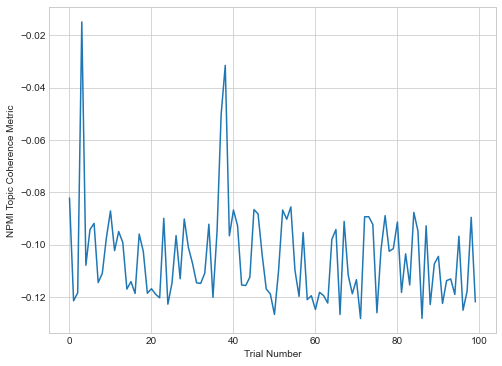

In [30]:
## Plot topic cohernece as function of the trial
%matplotlib inline

plt.rcParams['figure.figsize'] = [8,6]

(pd.Series(trials.losses())).plot(kind='line',
                                 xlabel='Trial Number',
                                 ylabel='NPMI Topic Coherence Metric',
                                 grid=True)

In [31]:
##########################################################
##
## Get optimal hyper-parameter values - and refit model to training data 
##
##########################################################

In [32]:
## Optimla NMF hyper-parameters
hyper_params = best_hyper_params

hyper_params['random_state'] = rand_

max_iter_indicator = best_hyper_params['max_iter']
hyper_params['max_iter'] = np.arange(300)[max_iter_indicator] + 100

n_components_indicator = best_hyper_params['n_components']
hyper_params['n_components'] = np.arange(250)[n_components_indicator] + 2

solver_indicator = best_hyper_params['solver']
hyper_params['solver'] = ['cd', 'mu'][solver_indicator]

beta_loss_indicator = best_hyper_params['beta_loss']
hyper_params['beta_loss'] = ['frobenius'][beta_loss_indicator]

init_indicator = best_hyper_params['init']
hyper_params['init'] = ['random'][init_indicator]

hyper_params

{'alpha_H': 3.049232854090043e-06,
 'alpha_W': 4.7678395180803266e-06,
 'beta_loss': 'frobenius',
 'init': 'random',
 'l1_ratio': 0.8106806109996593,
 'max_iter': 285,
 'n_components': 60,
 'solver': 'cd',
 'random_state': 123421}

In [34]:
## Refit model on training set
t0 = time.time()
final_model = NMF(**hyper_params)
theta = final_model.fit_transform(sp_dtm)
t1 = time.time()
t1-t0

C:\Users\meaneych\Anaconda3\envs\pyenv_topicmodels3\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 285 reached. Increase it to improve convergence.
  ConvergenceWarning,


120.44551992416382

In [35]:
# help(final_model)

In [36]:
## Convert to pandas dataframe
theta_pd = pd.DataFrame(theta)
theta_pd.shape

(12276, 60)

In [37]:
## Rename columns in matrix of learned per-doc topic prevalence vecs
k = theta_pd.shape[1]

theta_colnames = ["Topic" + str(num+1) for num in range(k)]
theta_pd.columns = theta_colnames
# theta_pd

In [38]:
## Extract the topical vectors
t0 = time.time()
phi = final_model.components_
t1 - time.time()
fit_time = t1-t0
fit_time

-0.26446056365966797

In [39]:
## Convert to pandas dataframe
phi_pd = pd.DataFrame(phi)
# phi.shape

In [40]:
## Assign colnames to topic matrix
phi_pd.columns = vocab.vocab.tolist()
# phi_pd

In [41]:
#####################################
## Frobenius norm error
#####################################
frob_norm_error = final_model.reconstruction_err_
frob_norm_error

1840.1819144863791

In [42]:
####################################################
##
## 
## Summarize top-P words occuring for each topic k=1...K of matrix phi (these will provide topical/thematic summary of corpus)
##
##
####################################################

In [43]:
phi_pd_ = phi_pd.div(phi_pd.sum(axis=1), axis=0)
# phi_pd_

In [44]:
def get_top_words(topic, num_words):
    vec = phi_pd_.iloc[topic,:].sort_values(ascending=False).head(n=num_words)
    vec_toks = vec.index.tolist()
    vec_vals = vec.tolist() 
    vec_out = [tok + "  (" + str(np.round(val,2)) + ")" for tok, val in zip(vec_toks, vec_vals)]
    return vec_out

# get_top_words(1,10)

In [45]:
topic_list = []

for i in np.arange(k):
    topic_list.append( get_top_words(topic=i, num_words=10) )

topic_list

[['outcomes  (0.23)',
  'outcome  (0.02)',
  'secondary  (0.01)',
  'birth  (0.01)',
  'maternal  (0.01)',
  'pregnancy  (0.01)',
  'effects  (0.01)',
  'adverse  (0.01)',
  'measures  (0.01)',
  'improved  (0.01)'],
 ['smoking  (0.12)',
  'cessation  (0.06)',
  'tobacco  (0.03)',
  'quit  (0.02)',
  'smokers  (0.02)',
  'abstinence  (0.01)',
  'cigarette  (0.01)',
  'nicotine  (0.01)',
  'cigarettes  (0.01)',
  'ecigarettes  (0.01)'],
 ['studies  (0.17)',
  'included  (0.03)',
  'bias  (0.01)',
  'reported  (0.01)',
  'criteria  (0.01)',
  'searched  (0.01)',
  'pooled  (0.01)',
  'assessed  (0.01)',
  'review  (0.01)',
  'metaanalysis  (0.01)'],
 ['people  (0.22)',
  'living  (0.01)',
  'population  (0.01)',
  'aged  (0.01)',
  'prison  (0.01)',
  'prescribed  (0.01)',
  'carers  (0.01)',
  'conditions  (0.01)',
  'overdose  (0.01)',
  'drugs  (0.01)'],
 ['practice  (0.09)',
  'physicians  (0.06)',
  'practices  (0.05)',
  'family  (0.03)',
  'physician  (0.02)',
  'medicine  (0.01)'

In [46]:
#################################################
##
##
## Get top-P documents loading most strongly on each of the k=1...K topical vectors of corpus
##
##
##################################################

In [47]:
theta_pd_ = theta_pd.div(theta_pd.sum(axis=1), axis=0)
#theta_pd_

In [48]:
#theta_pd_.describe()

In [49]:
#theta_pd_.quantile(q=[0,0.1,0.5,0.75,0.90,0.95,0.975,0.99,1.00])

In [50]:
X_theta = pd.concat([X.reset_index(drop=True), theta_pd_], axis=1)
X_theta.shape

(12276, 86)

In [51]:
X_theta.columns.values

array(['au_id', 'prism_url', 'eid', 'doi', 'issn', 'eissn', 'pub_title',
       'pub_author', 'pub_journal', 'pub_date', 'pub_abstract',
       'pub_keywords', 'pub_type', 'pub_subtype', 'open_access',
       'fund_acr', 'fund_num', 'fund_sponsor', 'cited_count', 'nam', 'id',
       'pub_year', 'au_country', 'au_institution', 'au_name',
       'au_institution_country', 'Topic1', 'Topic2', 'Topic3', 'Topic4',
       'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10',
       'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16',
       'Topic17', 'Topic18', 'Topic19', 'Topic20', 'Topic21', 'Topic22',
       'Topic23', 'Topic24', 'Topic25', 'Topic26', 'Topic27', 'Topic28',
       'Topic29', 'Topic30', 'Topic31', 'Topic32', 'Topic33', 'Topic34',
       'Topic35', 'Topic36', 'Topic37', 'Topic38', 'Topic39', 'Topic40',
       'Topic41', 'Topic42', 'Topic43', 'Topic44', 'Topic45', 'Topic46',
       'Topic47', 'Topic48', 'Topic49', 'Topic50', 'Topic51', 'Topic52',
       'T

In [52]:
topics = ["Topic"+str(i+1) for i in np.arange(k)]
topics

['Topic1',
 'Topic2',
 'Topic3',
 'Topic4',
 'Topic5',
 'Topic6',
 'Topic7',
 'Topic8',
 'Topic9',
 'Topic10',
 'Topic11',
 'Topic12',
 'Topic13',
 'Topic14',
 'Topic15',
 'Topic16',
 'Topic17',
 'Topic18',
 'Topic19',
 'Topic20',
 'Topic21',
 'Topic22',
 'Topic23',
 'Topic24',
 'Topic25',
 'Topic26',
 'Topic27',
 'Topic28',
 'Topic29',
 'Topic30',
 'Topic31',
 'Topic32',
 'Topic33',
 'Topic34',
 'Topic35',
 'Topic36',
 'Topic37',
 'Topic38',
 'Topic39',
 'Topic40',
 'Topic41',
 'Topic42',
 'Topic43',
 'Topic44',
 'Topic45',
 'Topic46',
 'Topic47',
 'Topic48',
 'Topic49',
 'Topic50',
 'Topic51',
 'Topic52',
 'Topic53',
 'Topic54',
 'Topic55',
 'Topic56',
 'Topic57',
 'Topic58',
 'Topic59',
 'Topic60']

In [53]:
def get_top_docs(topic, num_docs):
    theta_sort = X_theta.sort_values(by=topic, ascending=False)
    vals = theta_sort[[topic]].head(num_docs).to_numpy()
    notes = theta_sort.pub_abstract.head(num_docs).to_numpy()
    out = ["(" + str(np.round(v[0],3)) + ")  " + n for n, v in zip(notes, vals)]
    return out

In [54]:
## Loop over all of the topics, grabbing top-documents under given topic
doc_list = []

for topic_ in topics:
    doc_list.append(get_top_docs(topic=topic_, num_docs=5))
    
doc_list

[['(0.662)  Objective: To quantify the effect of different methodological decisions on the identification of potential core outcomes to inform the development of recommendations\xa0for future core coutcome set developers. Design: Mixed methods study. Setting: A core outcome set for pre-eclampsia was used as an exemplar. Sample: A long list of potential core outcomes was developed by undertaking a systematic review of pre-eclampsia trials and performing a thematic analysis of in-depth patient interviews. Methods: Specific methods used to generate long lists of potential core outcomes were evaluated. Results: Different methodological decisions had a substantial impact on the identification of potential core outcomes. Extracting outcomes from published pre-eclampsia trials was an effective way of identifying 48 maternal, eight fetal, 25 neonatal outcomes, and eight patient-reported outcomes. Limiting the extraction of outcomes to primary outcomes or outcomes commonly reported in pre-eclam

In [55]:
########################
## Print topic-labels and top-documents
########################

In [56]:
for i in np.arange(k):
    print("Topic" + str(i) + "\n")
    print(" ".join(topic_list[i]), "\n")
    print("\t\t\n".join(doc_list[i]), "\n")
    print("\n\n\n")

Topic0

outcomes  (0.23) outcome  (0.02) secondary  (0.01) birth  (0.01) maternal  (0.01) pregnancy  (0.01) effects  (0.01) adverse  (0.01) measures  (0.01) improved  (0.01) 

(0.662)  Objective: To quantify the effect of different methodological decisions on the identification of potential core outcomes to inform the development of recommendations for future core coutcome set developers. Design: Mixed methods study. Setting: A core outcome set for pre-eclampsia was used as an exemplar. Sample: A long list of potential core outcomes was developed by undertaking a systematic review of pre-eclampsia trials and performing a thematic analysis of in-depth patient interviews. Methods: Specific methods used to generate long lists of potential core outcomes were evaluated. Results: Different methodological decisions had a substantial impact on the identification of potential core outcomes. Extracting outcomes from published pre-eclampsia trials was an effective way of identifying 48 maternal, 

In [57]:
###############################################################
## Mean Prevalence Vectors in Each Year of Study
###############################################################

In [58]:
topic_vars = ["Topic" + str(x) for x in np.arange(k)]
topics_by_year = X_theta[X_theta.columns.intersection(topic_vars)].groupby(X_theta.pub_year).mean()
topics_by_year

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,...,Topic35,Topic36,Topic37,Topic38,Topic39,Topic40,Topic41,Topic42,Topic43,Topic44,Topic45,Topic46,Topic47,Topic48,Topic49,Topic50,Topic51,Topic52,Topic53,Topic54,Topic55,Topic56,Topic57,Topic58,Topic59
pub_year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017,0.028881,0.017252,0.030343,0.014563,0.022378,0.026631,0.007852,0.009785,0.016703,0.023094,0.026813,0.028605,0.020047,0.011372,0.016955,0.018660,0.016593,0.017598,0.030447,0.013204,0.015592,0.013571,0.012169,0.013761,0.017112,...,0.007562,0.020951,0.014310,0.013742,0.034564,0.017527,0.018325,0.008535,0.011351,0.033801,0.023953,0.017414,0.009365,0.009983,0.012829,0.001426,0.017984,0.019616,0.016283,0.020009,0.014608,0.006801,0.011675,0.016150,0.020700
2018,0.029751,0.015319,0.031923,0.014795,0.024365,0.024089,0.005503,0.009201,0.018996,0.024670,0.026480,0.029038,0.021292,0.008772,0.016257,0.017412,0.015187,0.018061,0.028803,0.013708,0.014191,0.012480,0.013642,0.012515,0.015557,...,0.006955,0.018956,0.015636,0.013652,0.034911,0.015904,0.018149,0.008511,0.013111,0.033884,0.024716,0.018196,0.010864,0.010871,0.011486,0.001725,0.019300,0.016967,0.014700,0.020133,0.017371,0.005739,0.011823,0.017458,0.023416
2019,0.030384,0.016817,0.029709,0.015944,0.024784,0.023259,0.005891,0.011512,0.018166,0.023774,0.029878,0.026527,0.020739,0.008101,0.016857,0.015572,0.015424,0.018153,0.029018,0.011630,0.014623,0.011379,0.015729,0.012886,0.015937,...,0.008142,0.019230,0.012554,0.012414,0.038281,0.015779,0.019225,0.008485,0.009808,0.037967,0.022552,0.018265,0.012825,0.009886,0.010337,0.001525,0.018462,0.015460,0.016126,0.020845,0.015514,0.005112,0.012462,0.016243,0.024887
2020,0.032074,0.012990,0.029642,0.019399,0.022373,0.024285,0.005303,0.010585,0.017577,0.024797,0.030450,0.026720,0.022661,0.009886,0.015499,0.015763,0.014655,0.017045,0.030121,0.011518,0.014075,0.011150,0.014734,0.010965,0.015428,...,0.008382,0.019258,0.012766,0.011359,0.037860,0.017078,0.017401,0.009944,0.009450,0.036391,0.023790,0.019346,0.012238,0.010222,0.011856,0.010473,0.014515,0.014932,0.015922,0.022680,0.013949,0.005841,0.013006,0.018731,0.023674
2021,0.033378,0.010837,0.029149,0.018713,0.021034,0.027031,0.004773,0.008960,0.016582,0.021467,0.028937,0.026311,0.022046,0.009491,0.015736,0.016700,0.015895,0.016101,0.029257,0.012818,0.014862,0.012278,0.012872,0.009142,0.016820,...,0.008858,0.020321,0.013819,0.012655,0.035034,0.016030,0.016140,0.008214,0.009243,0.036621,0.022550,0.017834,0.009650,0.009735,0.013610,0.023342,0.013425,0.014505,0.014674,0.021761,0.017595,0.005583,0.014311,0.017231,0.020475
2022,0.034346,0.012912,0.026785,0.020667,0.021866,0.027620,0.005061,0.009053,0.015338,0.022852,0.029684,0.024735,0.019544,0.008658,0.012235,0.016567,0.015337,0.017929,0.029454,0.014421,0.013805,0.010861,0.012521,0.010031,0.015400,...,0.007655,0.020562,0.010978,0.010594,0.037246,0.016473,0.016638,0.007018,0.009884,0.036239,0.021187,0.020035,0.009782,0.011580,0.010675,0.028447,0.015778,0.014049,0.012983,0.022603,0.014399,0.004431,0.014682,0.018424,0.021867


In [59]:
###############################################################
## Write learned objects to disk...
###############################################################

In [60]:
fpath_theta = "D:\\CopyZ_30Nov2020\\DFCM_Docs\\DFCM_Researchers\\PeterSelby\\MineScopus_DFCM_National_International_PrimaryCareResearchPrograms\\Output_TopicModels\\NMF_X_theta.csv"

X_theta.to_csv(path_or_buf=fpath_theta,
                      encoding="utf-8",
                      index=False)

In [61]:
phi_pd.to_csv(path_or_buf="D:\\CopyZ_30Nov2020\\DFCM_Docs\\DFCM_Researchers\\PeterSelby\\MineScopus_DFCM_National_International_PrimaryCareResearchPrograms\\Output_TopicModels\\NMF_phi.csv",
                      encoding="utf-8",
                      index=False)

In [62]:
#############################
## Session Info
#############################
import IPython
print(IPython.sys_info())

{'commit_hash': '3813660de',
 'commit_source': 'installation',
 'default_encoding': 'cp1252',
 'ipython_path': 'C:\\Users\\meaneych\\Anaconda3\\envs\\pyenv_topicmodels3\\lib\\site-packages\\IPython',
 'ipython_version': '7.29.0',
 'os_name': 'nt',
 'platform': 'Windows-10-10.0.17763-SP0',
 'sys_executable': 'C:\\Users\\meaneych\\Anaconda3\\envs\\pyenv_topicmodels3\\python.exe',
 'sys_platform': 'win32',
 'sys_version': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, '
                '05:37:49) [MSC v.1916 64 bit (AMD64)]'}


In [63]:
#sinfo()